In [29]:
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, add, Flatten
from keras.models import Model
from keras.regularizers import l2
from keras.utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, f1_score

In [2]:
from mish import Mish

# Load datasets, split, normalize etc..

In [3]:
datasets = np.load("datasets.npy")
labels = np.load("labels.npy")

datasets_val = np.load("datasets_val.npy")
labels_val = np.load("labels_val.npy")

In [4]:
datasets.shape

(1052, 250, 16, 60)

In [5]:
X_train,X_test,y_train, y_test = train_test_split(datasets, labels, test_size=0.05,random_state=4242)

In [6]:
# min-max normalization (can try other also..)

def norm_dataset_minMax(dataset):
    for i in range(len(dataset)):
        d = dataset[i]
        d = (d-d.min()) / (d.max()-d.min())
        dataset[i] = d
    return dataset

def norm_dataset_meanStd(dataset):
    for i in range(len(dataset)):
        d = dataset[i]
        d = (d-d.mean()) / d.std()
        dataset[i] = d
    return dataset

In [7]:
def print_statistics(dataset):
    print("min:{:.3f} max:{:.3f} mean:{:.3f} std:{:.3f}".format(dataset.min(), dataset.max(), dataset.mean(), dataset.std()))

In [8]:
X_train = norm_dataset_meanStd(X_train)
X_test = norm_dataset_meanStd(X_test)
X_val = norm_dataset_meanStd(datasets_val)

In [9]:
print_statistics(X_train)
print_statistics(X_test)
print_statistics(X_val)

min:-1.547 max:74.888 mean:-0.000 std:1.000
min:-1.376 max:62.494 mean:0.000 std:1.000
min:-1.411 max:49.713 mean:-0.000 std:1.000


- Make channel the last axis

In [10]:
X_train = np.swapaxes(X_train, -2, -1)
X_test = np.swapaxes(X_test, -2, -1)
X_val = np.swapaxes(X_val, -2, -1)

In [11]:
X_test.shape

(53, 250, 60, 16)

- Labels to one hot

In [12]:
def to_numericalLabel(x):
    if x == "left":
        return 0
    elif x == "none":
        return 1
    elif x == "right":
        return 2

In [13]:
y_train = [to_numericalLabel(l) for l in y_train]
y_test = [to_numericalLabel(l) for l in y_test]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [14]:
y_train[:10]

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [15]:
y_test[:10]

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [16]:
y_val = [to_numericalLabel(l) for l in labels_val]
y_val = to_categorical(y_val)

# Try #1: simple conv net

- 2D conv and max poolings, with skip connections (add)
- Dense at the end for classification

In [32]:
input_img = Input(shape=(250,60,16))   ## 16 channels

In [33]:
learning_rate = 5e-4  ## 1e-3 is default for adam
reg_param = 1e-2

In [34]:
def net_model(input_img):
    conv1 = Convolution2D(32, (3,3), activation="Mish", padding="same", kernel_regularizer=l2(reg_param))(input_img)
    # add1  
    pool1 = MaxPooling2D((2,2), padding="same")(conv1)
    
    conv2 = Convolution2D(32, (3,3), activation="Mish", padding="same", kernel_regularizer=l2(reg_param))(pool1)
    add2 = add([pool1, conv2])
    pool2 = MaxPooling2D((2,2), padding="same")(add2)
    
    conv3 = Convolution2D(32, (3,3), activation="Mish", padding="same", kernel_regularizer=l2(reg_param))(pool2)
    add3 = add([pool2, conv3])
    pool3 = MaxPooling2D((2,2), padding="same")(add3)
    
    conv4 = Convolution2D(32, (3,3), activation="Mish", padding="same", kernel_regularizer=l2(reg_param))(pool3)
    add4 = add([pool3, conv4])
    pool4 = MaxPooling2D((2,2), padding="same")(add4)
    
    conv5 = Convolution2D(32, (3,3), activation="Mish", padding="same", kernel_regularizer=l2(reg_param))(pool4)
    add5 = add([pool4, conv5])
    pool5 = MaxPooling2D((2,2), padding="same")(add5)
    
    flatten = Flatten()(add5)
    #dense1 = Dense(256, activation="Mish")(flatten)
    #dense2 = Dense(32, activation="Mish")(dense1)
    preds = Dense(3, activation="softmax")(flatten)
    
    return preds

In [35]:
nnet = Model(inputs=input_img, outputs=net_model(input_img))

In [36]:
nnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 250, 60, 16)  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 250, 60, 32)  4640        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 125, 30, 32)  0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 125, 30, 32)  9248        max_pooling2d_6[0][0]            
____________________________________________________________________________________________

In [37]:
nnet.compile(optimizer=Adam(lr=learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])

In [38]:
nnet.fit(x=X_train, y=y_train, batch_size=32, epochs=50, validation_data=(X_test,y_test))

Train on 999 samples, validate on 53 samples
Epoch 1/50
999/999 [==============================] - 17s 17ms/step - loss: 3.1340 - accuracy: 0.3534 - val_loss: 2.5861 - val_accuracy: 0.4340
Epoch 2/50
999/999 [==============================] - 17s 17ms/step - loss: 2.4655 - accuracy: 0.4875 - val_loss: 2.5292 - val_accuracy: 0.4906
Epoch 3/50
999/999 [==============================] - 19s 19ms/step - loss: 2.3267 - accuracy: 0.5666 - val_loss: 2.3891 - val_accuracy: 0.3962
Epoch 4/50
999/999 [==============================] - 21s 21ms/step - loss: 2.1721 - accuracy: 0.6186 - val_loss: 2.3609 - val_accuracy: 0.4151
Epoch 5/50
999/999 [==============================] - 21s 21ms/step - loss: 2.0605 - accuracy: 0.6817 - val_loss: 2.3059 - val_accuracy: 0.5472
Epoch 6/50
999/999 [==============================] - 21s 21ms/step - loss: 1.9565 - accuracy: 0.7247 - val_loss: 2.2523 - val_accuracy: 0.5094
Epoch 7/50
999/999 [==============================] - 21s 21ms/step - loss: 1.8642 - accura

### Check results

In [44]:
### https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [45]:
val_preds = nnet.predict(X_val)

Normalized confusion matrix
[[0.42553191 0.21276596 0.36170213]
 [0.10638298 0.70212766 0.19148936]
 [0.29787234 0.36170213 0.34042553]]


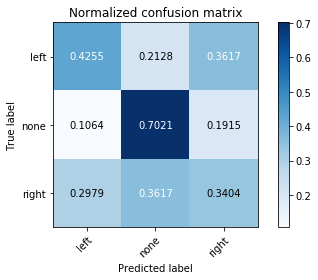

In [46]:
plot_confusion_matrix(y_val.argmax(axis=1), val_preds.argmax(axis=1), ["left","none","right"], normalize=True)

In [42]:
acc = accuracy_score(y_val.argmax(axis=1), val_preds.argmax(axis=1))
f1 = f1_score(y_val.argmax(axis=1), val_preds.argmax(axis=1) , average="weighted")

In [43]:
print("accuracy:{:.4f} f1:{:.4f}".format(acc, f1))

accuracy:0.4894 f1:0.4805
